# Perturbation Analysis for Parabolic Partial Differential Equations

In [1]:
import numpy as np
import scipy as sc
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from ipywidgets import *
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 15

In [2]:
def cubic_spline(x, y, end=None, k1=0, k2=0, p1=0, p2=0):
    #x: x-coordinates of points
    #y: y-coordinates of points
    #end: Natural, Adjusted, Clamped, Parabolically, NaK
    
    n = len(x)
    A = np.zeros((3*n-3, 3*n-3))
    b = np.zeros(3*n-3)
    
    delta_x=np.diff(x)
       
    #Building the linear system of equations
    
    #1st property
    for i in np.arange(n-1):
        b[i]= y[i+1]-y[i]
        A[i,3*i:3*(i+1)] = [delta_x[i],delta_x[i]**2,delta_x[i]**3]
    #2nd property
    for i in np.arange(n-2):
        A[(n-1)+i,3*i:3*(i+1)+1]=[1, 2*delta_x[i], 3*delta_x[i]**2, -1]
    #3rd property
    for i in np.arange(n-2):
        A[(n-1)+(n-2)+i,3*i:3*(i+1)+2] = [0, 2, 6*delta_x[i], 0, -2]
    
    #Ending conditions (4th property)
    if end =='Natural':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]

    elif end == 'Adjusted':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]
        b[-2:] = [k1,k2]
        print('Adjusted',b[-2:])

    elif end == 'Clamped':
        A[-2,0]=1
        A[-1,-3:] = [1,2*delta_x[-1],3*delta_x[-1]**2]
        b[-2:] = [p1,p2]

    elif end == 'Parabolically':
        A[-2,2]=1
        A[-1,-1]=1

    elif end == 'NaK':
        A[-2,2:6]=[6,0,0,-6]
        A[-1,-4:]=[6,0,0,-6]
    
    #Solving the system
    sol = np.linalg.solve(A,b)
    S = {'b':sol[::3],
         'c':sol[1::3],
         'd':sol[2::3],
         'x':x,
         'y':y
        }
    return S

def cubic_spline_eval(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=float("nan")
    for i in np.arange(n-1):
        if x[i] <= xx and xx <= x[i+1]:
            yy = y[i]+b[i]*(xx-x[i])+c[i]*(xx-x[i])**2+d[i]*(xx-x[i])**3
    return yy

def cubic_spline_eval2(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=np.zeros_like(xx)
    for i in np.arange(n-1):
        jj = np.where(np.logical_and(x[i]<=xx,xx<=x[i+1]))
        yy[jj]=y[i]+b[i]*(xx[jj]-x[i])+c[i]*(xx[jj]-x[i])**2+d[i]*(xx[jj]-x[i])**3
    return yy

In [3]:
def bisect(f, a, b, verb=False, tol=10e-12):
    fa = f(a)
    fb = f(b)
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
    
    if verb:
        #Printing the evolution of the computation of the root
        print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
        print('----------------------------------------------------------------------------------------')
    
    while(b-a)/2 > tol:
        c = (a+b)/2.
        fc = f(c)
        if verb:
            print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' % (i+1, a, c, b, fa, fc, fb, b-a))
        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        i += 1
        
    xc = (a+b)/2.
    return xc

In [4]:
def simpsons(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        if verbose: print("Simpsons rule only applicable to even number of segments")
        return np.nan
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    if verbose:
        xbin, ybin = simpsons_bins(f, xleft, xmiddle, xright)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

In [5]:
def plot_functions(w,F):
    th = np.linspace(0,4*np.pi,200)
    thh = np.linspace(0,2*np.pi,100)
    W = w(th)
    
    plt.figure(figsize=(18,5))
    
    plt.subplot(121)
    plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
    plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
    plt.xlim(-1,12)
    plt.ylim(-4,4)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=2*np.pi, color='k', linestyle='--')
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.legend(loc="best")
    
    plt.subplot(122)
    plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")
    plt.xlim(-1,7)
    plt.ylim(-4,4)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=2*np.pi, color='k', linestyle='--')
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$F(\theta)$")
    plt.legend(loc="best")
    plt.show()

In [6]:
#for testing
def w(theta):
    return theta**0
    #return (np.sin(0.5*theta))**2+0.5
    #return (np.cos(0.5*theta))**2+0.5
def wp(theta):
    return theta*0
    #return 0.5*np.sin(theta)
    #return -2*np.sin(2*theta)
def F(theta):
    return 2*np.sin(theta)

## Introduction

Commonly, exist some phenomena that can be represented as mathematical models, using differential equations. In some cases, simplificationes in the moment of making the model can reduce the difficulty of the representation, but in change, the model could not consider the effect of small factors that are occurring.

Parabolic Partial Differential Equations model different process in the scope of Engineering and Science. One representative Parabolic Partial Differential Equation is the following:
$$
\frac{\partial u(x,t)}{\partial t} = d\,\frac{\partial^2 u(x,t)}{\partial x^2} + c\,\frac{\partial u(x,t)}{\partial x}
$$

Tipically there are processes involved in this equation: advection, difusion and reaction. 

## Method of multiple scales

The method of multiple scales is a general method applicable in a wide range of problems. In this problems there are two processes acting at the same time, each one with its own scale. 
The problem of determinate $u(x,t)$ usually has an approximated value using the approximation:

$$
u(x,t, \varepsilon) \approx u_0(x,t) + \varepsilon \, u_1(x,t)
$$

This expansion works fine with a fixed value of $t$ and $\varepsilon$ near to zero. However, there are problems if $t \geq \mathcal{O}(\varepsilon ^{-1})$. There are two processes acting simultaneously that has its own scales. So, it is necessary to introduce two time variables:

- $\tau = t$ the _fast time_
- $T = \varepsilon t$ the _slow time_

With this variables, the solution proposed by the method has the form:

$$
u(x,t,\varepsilon) \approx u(x,\tau, T, \varepsilon)
$$

In this maner, variations of time must be deteminated in function of the variations of the _fast time_ and _slow time_. In terms of algebra:

$$
\frac{\mathrm{d}}{\mathrm{d}t} = \left( \frac{ \partial }{\partial \tau} \right) + \varepsilon \left( \frac{\partial}{\partial T} \right)
$$

Finally, the approximation for $u(x,t)$ that is asymptotic for $T = \mathcal{O}(1)$ is:

$$
u(x,t,\varepsilon) \approx u_0(x,\tau,T) + \varepsilon\, u_1(x,\tau,T)
$$

The next step is to determinate the functions $u_k$, replacing into the partial differential equation and comparing coefficients of $\varepsilon^k$ as usual.

## A diffusion-advection equation

### Application of the Method of multiple scales

Consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

 As can be seen there are two process acting at simultaneously: advection on the fast time scale and difusion on the slow scale. According to the method, the next expansion is used:
 
$$
u(\theta,t,\varepsilon) \approx u_0(\theta,\tau,T) + \varepsilon\, u_1(\theta,\tau,T)
$$

Sustituing into the equation and comparing coefficients there are derivated problems to solve.

**First problem**

$
\mathcal{O}(1):
$

$$
\frac{\partial u_0}{\partial \tau} + \frac{\partial}{\partial \theta}(\omega(\theta) \, u_0) = 0
$$

The first problem can be rewrited as:

$$
\frac{1}{\omega} \left( \frac{\partial}{\partial \tau} + \omega \frac{\partial}{\partial \theta}\right) (\omega\, u_0) = 0
$$

This is an advection problem that depends only of the fast time, no slow time are implicated. An observed moving at  a speed $\omega$ will see the quantity $\omega \, u_0$ remain constant. If the value of $\omega(\theta)$ was $\omega(\theta) = \omega$, where $\omega$ is constant, the solution is reduced to $u_0(\theta,\tau,T) = F(\theta-\omega\tau)$, where $F(\theta)$ is the initial value. However, in a general scenario, is necessary to know how much advanced is done after a time $\tau$. Consider the following initial value problem:

\begin{align*}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= \omega(\theta)\\
\theta(0) &= 0
\end{align*}

The next function solves the Initial Value Problem explained before using the Forward Euler Method. The return of this function is the function $\Theta(t)$ constructed from a cubic spline. Also, the period of the function $\Theta(t)$ was computed dividing the reconstructed funcion form cubic spline [2] into $2\pi$. A verification of the period was employed using the Bisection method [1] using the zero of a function $T(s)$ that will be explained later. 

In [60]:
def solve_IVP(w,t_max=10,show_plot=False):
    #using Explicit Euler Method to estimate de IVP
    t = np.linspace(0,t_max,50)
    tt = np.linspace(0,t_max,1000)
    h = t[1] - t[0]
    theta = np.zeros(t.shape)
    theta[0] = 0
    for i in range(t.shape[0]-1):
        theta[i+1] = theta[i] + h*w(theta[i])
    
    #compute cubic splines for estimate the funtion
    spl = cubic_spline(t,theta,end="Natural")
    
    if show_plot:
        plt.figure(figsize=(8,5))
        #plot points of the numerical solution for theta
        plt.plot(t,theta,"ro",label=r"$\Theta(t)$")    
        #plot spline function using the previous points
        plt.plot(tt,cubic_spline_eval2(tt,spl),"-g",label=r"Splines for $\Theta(t)$")
        
        #get the period of the function
        #th = [2*np.pi,4*np.pi,6*np.pi]
        th = [2*np.pi]
        list_s = []   

        for i in th:
            f = lambda x: cubic_spline_eval(x,spl) - i
            #obtain the time s where theta(s) = 2pi, 4pi and 6pi
            s = bisect(f,0,t_max,verb=False)
            #plot a vertical line
            plt.axvline(x=s, color='k', linestyle='--')
            list_s.append(s)

        #plot the points where theta(s) = 2pi, 4pi and 6pi
        plt.plot(list_s,th,"Db")   
        
        #plot the spline functions mod 2pi to verify the period
        plt.plot(tt,(cubic_spline_eval2(tt,spl)%(2*np.pi)),"-b",label=r"$\Theta(t)$ mod $2\pi$")
        #other configurations of the plot
        plt.grid(True)
        plt.legend(loc="best")
        plt.xlabel(r"$t$")
        plt.ylabel(r"$\Theta(t)$")
        plt.title("Period P = "+str(list_s[0])+" [s]")
        #save image in pdf
        plt.savefig("Theta.pdf")
        plt.show()
        
    Theta = lambda x: cubic_spline_eval(x,spl)
    
    return Theta

Supouse that $\Theta(t)$ is the solution of this problem. Then, $\theta(t)$ is a periodic function with period $P$. In order to solve the problem, a change of variable to Lagrangian coordinates $s$ and $\tau$ will be done. Let:

$$
\theta(s,\tau) = \Theta(\tau - s)
$$

Where $s$ is the **time delay** since $\theta$ was zero.

Using the chain rule to recast the differential equation, the following equalities are valid:
    
\begin{align*}
\left(\frac{\partial}{\partial \tau} \right)_s &= \left( \frac{\partial}{\partial \tau}  \right)_\theta + \omega \left( \frac{\partial}{\partial \theta} \right)_{\tau}\\
\left( \frac{\partial}{\partial \theta} \right)_\tau &= -\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}
\end{align*}
    

Replacing into the equation, the problem is reduced to:

$$
\left(\frac{\partial}{\partial \tau} \right)_s (\omega\,u_0) = 0
$$

Which has constant solution for variable $\tau$ in this coordinate system. The value of $u_0$ can be determinated defining a function $A_0$, which depends of $s$ and $T$ and the speed $\omega$:

$$
u_0(\theta, \tau, T) = \frac{A_0(s,T)}{\omega(\theta)}
$$

This shows that an observed moving at a speed $\omega(\theta)$ will see the quantity $\omega\,u_0$ remain constant. But, this constant is allowed to modify its value in the slow scale $T$. The initial value of this _constant_ is given by the initial condition of the problem:

$$
A_0(s,0) = F(\Theta(-s))\omega(\Theta(-s))
$$


In order to deteminate $A_0$ the second problem must be aborded.

**Second Problem**

$
\mathcal{O}(\varepsilon):
$

$$
\frac{\partial u_0}{\partial T}+ \frac{\partial u_1}{\partial \tau} + \frac{\partial}{\partial \theta} (\omega(\theta) \, u_1) = \frac{\partial^2 u_0}{\partial \theta^2}
$$

Replacing the partially determined $u_0$, the problem becomes:

$$
\frac{1}{\omega} \frac{\partial A_0}{\partial T} + \frac{1}{\omega} \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau} \frac{A_0}{\omega}
$$

with $\omega = \omega(\Theta(\tau-s))$ a $P$-periodic function of $s$ and $\tau$. Thus:

$$
\frac{\partial A_0}{\partial T} + \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega^2} \frac{\partial^2A_0}{\partial s^2}+ \frac{3}{2} \frac{\partial}{\partial s}\left( \frac{1}{\omega^2} \right) \frac{\partial A_0}{\partial s}+\frac{1}{2}\frac{\partial^2}{\partial s^2} \left( \frac{1}{\omega^2}\right) A_0
$$

The right side of the equation has non zero average. In order to mantain the asymptoticness of the expansion of $f$ in $T = \mathcal{O}(1)$, the quantity $\omega \,u_1$ has to be bounded as $\tau$ increases. Thus, the average with respect to $\tau$ of the right hand side must be removed by setting equal to $\displaystyle\frac{\partial A_0}{\partial T}$. The second and third terms of the right side has zero average because they are derivatives with respect to $s$ of functions of $\omega$ and so derivatives with respect to $\tau$. The next equalty must be satisfied:

$$
\frac{\partial A_0}{\partial T} = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}
$$

The previous equation corresponds to a Parabolic PDE with diffusion coeficient equals to the average value of $1/\omega^2$, that can be solved numerically in order to detemine $A_0$.

**Generically**, the problem can be solve using a numerical aproximation for the integral and using the value obtained in the PDE:

$$
\begin{aligned}
\int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \approx \sum_{i=1}^{K} w_i \frac{1}{\omega^2(\Theta(\tau_i-s))} = c(s)
\end{aligned}
$$

Where $w_i$ is the weigh used in the sum of $K$ terms and depends of the numerical method used to estimate the value of the integral. Also, this value depends of temporal variable $s$. So, let $c(s)$ the value of the integral divided by the period $P$ using a numerical method.

Now, considering the PDE with the estimation of the integral, and using an implicit approach for the variable $T$ and central difference for the variable $s$:

$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= c(s) \frac{\partial^2A_0}{\partial s^2}
\end{aligned}
$$

The equations to be solved for $j = 1, 2, \ldots N$ are:

$$
- \sigma_j\,a_{j-1,n+1} + (1+2\,\sigma_j)\,a_{j,n+1}-\sigma_j\,a_{j+1,n} = a_{j,n}
$$

where $\sigma_j = \displaystyle\frac{c(s_j)\Delta T}{\Delta s^2}$. And $s$ is a periodic variable.


The next code implements the solution of this PDE, according to the previous explanation

In [53]:
def solve_a0(w,F,eps=0.01,t_max=10,points_s=50,points_T=500):
    Theta = solve_IVP(w,25)
    th1 = lambda x: Theta(x) - 2*np.pi
    th2 = lambda x: Theta(x) - 4*np.pi
    #t1 is the period P of Theta(t)
    t1 = bisect(th1,0,25,verb=False)
    #t2 is two periods of Theta(t)
    t2 = bisect(th2,0,25,verb=False)

    #take equidistant values in the s axis
    s = np.linspace(0,t1,points_s)
    delta_s = s[1] - s[0]
    
    #tau is taked between P and 2*P for correctly evaluation of Theta(t)
    tau = np.linspace(t1,t2,points_s)
    #vector c for save the values of c_j
    c = np.zeros_like(s)
    
    for j in range(s.shape[0]):
        #compute the numerical quadrature of myfun with variable s
        myfun = lambda x: 1/((w(Theta(x-s[j])))**2)
        #using simpsons rule, number points_s must be EVEN
        val = simpsons(myfun, points_s, t1, t2)/t1
        #saving the value of c_j
        c[j] = val
    
    #computing delta_T
    delta_T = (t_max)/points_T
    #compute the values of sigma_j
    sigma = (delta_T/(delta_s**0.5))*c
    
    #compute matrix
    A = np.zeros((points_s,points_s))
    for i in range(points_s):
        A[i][i] = 1+2*sigma[i]
        if i < points_s-1:
            A[i+1][i] = -sigma[i]
        if i > 0:
            A[i-1][i] = -sigma[i]
    A[-1][0] = -sigma[0]
    A[0][-1] = -sigma[-1]
    
    
    sols = np.zeros((points_s,points_T+1))
    for i in range(points_s):
        sols[i,0] = F(Theta(t1-s[i]))*w(Theta(t1-s[i]))
        
    for i in range(1,points_T+1):
        sols[:,i] = np.linalg.solve(A,sols[:,i-1])    
    return s,sols,delta_T

In [54]:
def print_simulation_a0(i):
    s,a0,d_T = solve_a0(w,F)
    plt.figure(figsize=(10,5))
    plt.plot(s,a0[:,i],"ro")
    plt.xlabel("$s$")
    plt.ylabel("$A_0(s,T)$")
    plt.title(r"$A_0(s,T)$ for $T = "+str(d_T*i)+"$")#"$, $t="+str(d_T*i/eps)+"$")
    plt.ylim(-3,3)
    plt.grid(True)
    plt.show()

Finally, in order to obtain $u_0(\theta,\tau,T)$, is necessary to determinate which $s$ corresponds to a value of $\theta$ given. For that, is necessary to know how much time has passed since $\theta = 0$, i.e., is precise to determinate a value $s$ such that $\Theta(s) = \hat{\theta}$, since $\Theta(0) = 0$. Let $T(s)$ be the function:

$$
T(s) = \Theta(s) - \hat{\theta}
$$

So, finding a root for $T(s)$, the values of $s$ for each $\theta$ can be obtained and the expresion for $u_0$ can be evaluated.

The next code implements the calculation of values for $u_0$ taking equdistant points in the $\theta$ axis from $0$ to $2\pi$. The bisection method [1] was used for obtain the zeros of $T(s)$ when was needed. 

In [10]:
def get_u0(w,F,i,eps=0.01,t_max=10,points_s=50,points_T=500):
    Theta = solve_IVP(w,25)
    th1 = lambda x: Theta(x) - 2*np.pi
    #get period of the function
    period = bisect(th1,0,25,verb=False)
    
    #computing A0(s,T)
    s, a0, delta_T = solve_a0(w,F)
    
    #obtain points between 0 and 2pi
    th = np.linspace(0,2*np.pi,50)
    
    #generate structure to save values of u0
    u_0 = np.zeros_like(th)    
    
    #compute cubic spline for a0 in T = i*delta_T
    spl = cubic_spline(s,a0[:,i],end="Natural")
    a_0 = lambda x: cubic_spline_eval(x,spl)

    for j in range(1,th.shape[0]):
        fun = lambda x: Theta(x)-th[j]
        s2 = bisect(fun,0,2*period,verb=False)
        u_0[j] = a_0(s2)/w(th[j])
        
    return th,u_0,delta_T

In [11]:
def print_simulation_u0(i,eps):
    th,u0,d_T = get_u0(w,F,i,eps)
    plt.figure(figsize=(10,5))
    plt.plot(th,f0,"gD")
    plt.xlabel("$\theta$")
    plt.ylabel("$u_0(\theta,\tau,T)$")
    plt.title(r"$A_0(s,T)$ for $T = "+str(d_T*i)+"$, $t="+str(d_T*i/eps)+"$")
    plt.ylim(-3,3)
    plt.grid(True)
    plt.show()

### Using Finite Difference Method

Next, the problem is solved numerically with finite differences with an implicit method. Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

The formulas of finite differences will be **backward in time** and **central in space** for the first derivative (in order to mantain the spatial derivative with a second order aproximation). Let $u_{i,n} \approx u(\theta_i,t_n)$, where $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.


$$
\begin{aligned}
\frac{\partial u(\theta,t)}{\partial t} &= \frac{u_{i,n}-u_{i,n-1}}{\Delta t} + \mathcal{O}(\Delta t)\\
\frac{\partial u(\theta,t)}{\partial \theta} &= \frac{u_{i+1,n}-u_{i-1,n}}{2\,\Delta \theta} + \mathcal{O}(\Delta \theta^2)\\
\frac{\partial^2 u(\theta,t)}{\partial \theta^2} &= \frac{u_{i-1,n}-2\,u_{i,n}+u_{i+1,n}}{\Delta \theta^2} + \mathcal{O}(\Delta \theta^2)\\
\end{aligned}
$$

Replacing into the PDE, the iterative step to obtain solutions in different values of time is:

$$
\left( \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i-1,n+1}+ \left( 1+\frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta}\Delta t + 2\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i,n+1} + \left(- \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\, u_{i+1,n+1} = u_{i,n}
$$

for $0 \leq i<N_{\theta}$ and $n>0$.

The following code implements finite difference method for this problem.

In [12]:
def implicit_method(w,wp,F,N,M,eps):
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)

    dth = Theta[1]-Theta[0]
    dt = T[1]-T[0]

    A = np.zeros((N-1,N-1))
    b = np.zeros((N,M))

    b[:-1,0] = F(Theta[:-1])
    b[-1] = b[0]
    
    alpha = ((eps*dt)/(dth**2))*np.ones(N)
    beta = (dt/dth)*w(Theta)
    gamma = dt*wp(Theta)
    delta = 0.5*(dt/dth)*w(Theta)
    
    
    for i in range(N-1):
        A[i,i] = 1+2*alpha[i]+gamma[i]
        A[i,i-1] = -alpha[i]-delta[i]
        if i<N-2:
            A[i,i+1] = -alpha[i]+delta[i]
        else:
            A[i,0] = -alpha[i]+delta[i]
    
    for j in range(M-1):
        b[:-1,j+1] = np.linalg.solve(A,b[:-1,j])
        b[-1,:] = b[0,:]
    return b

### Using FFT

The Fast Fourier Transform will be used to determine the spatial derivative of $u(\theta,t)$ knowing the value of $u$ in the initial time, i.e. since the value of $u(\theta,t=0)$ is known, the value of $\displaystyle\frac{\partial^n u(\theta, t=0)}{\partial \theta^n}$ can be determinated. Besides, the spatial variable is periodic with period equal to $2\pi$. Later, using a forward approach for the temporal variable, solutions of $u(\theta,t)$ will be obtained.

Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d} \omega(\theta)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

Let be $w^{(k)}_{j,n}$ the value obtained using FFT for the derivative of $k$ order for $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Let be $v_{j,n}$ the aproximation of $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Put all the previous definitions together, the problem is reduced to an iterative method that calculates the next time step using the information of the values of $u(\theta_j,t_n)$, the first derivative of $u(\theta_j,t_n)$ and the second derivative of $u(\theta_j,t_n)$ for the actual time. Consider that $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.

The iterative step to be used in this case is:

$$
v_{j,n+1} = \varepsilon\,\Delta t\,w_{j,n}^{(2)} - \omega(\theta_j)\,\Delta t\,w_{j,n}^{(1)}+(1-\omega'(\theta_j)\,\Delta t)v_{j,n}
$$
for $0 \leq j<N_{\theta}$ and $n>0$.


The next code implements the spectral derivative using FFT in order to obtain the derivative of $\nu$ order of a function $v$ valid for the spatial interval $[0,2\pi]$. The code was extracted from [1].

In [13]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

The next code implements the iterative step in order to solve this kind of problem.

In [14]:
def explicit_fft_method(w,wp,F,N,M,eps):
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)
    dt = T[1]-T[0]
    
    #defining a matrix to save all the values of the function in all the time steps
    v = np.zeros((N,M))
    #setting values for the initial time
    v[:,0] = F(Theta)
    
    w1 = np.zeros(N)
    w2 = np.zeros(N)
    
    #iterative step
    for n in range(M-1):
        #calculate the first derivative with FFT
        w1[1:] = spectralDerivativeByFFT(v[1:,n],1)
        w1[0] = w1[-1]
        #calculate the second derivative with FFT
        w2[1:] = spectralDerivativeByFFT(v[1:,n],2)
        w2[0] = w2[-1]
              
        #get the values of the function in the next time
        v[:,n+1] = eps*dt*w2 - dt*w(Theta)*w1+(np.ones(N)-dt*wp(Theta))*v[:,n]
    return v

### Numerical Examples

According to all the theoretical part explained before, two numerical examples will be tested for the diffusion and advection equation.

Again, consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

The first numerical example considers a constant value for the speed $\omega$. Let be:
\begin{align}
\omega(\theta) &= 1\\
\omega'(\theta) &= 0\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [15]:
def w(theta):
    return theta**0 
def wp(theta):
    return theta*0

def F(theta):
    return 2*np.sin(theta)

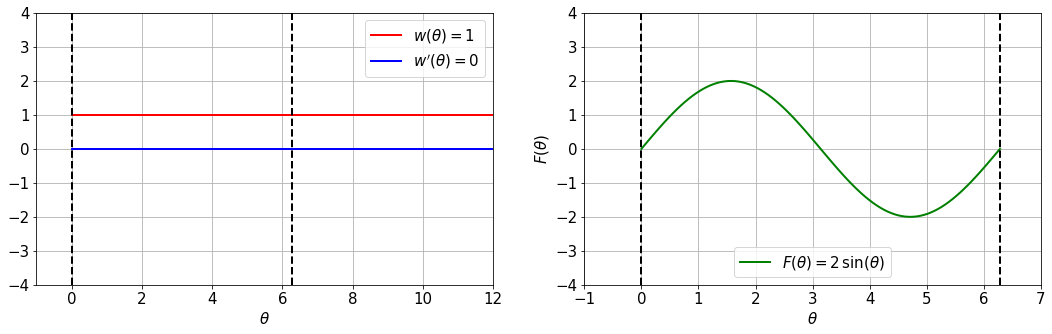

In [16]:
plot_functions(w,F)

As can be seen previously, the function $\omega(\theta)$ is a positive and periodic function around the interval $[0,2\pi]$. The derivative of a constant function is zero. The function $F(\theta)$ is shown between the same interval. 

The first approach for this example consists in determinate numerically the solution of the partial differential equation using Finite Differences and Explicit Fast Fourier Transform.

In [37]:
def simulation(i,N,M,eps):   
    y1 = explicit_fft_method(w,wp,F,N,M,eps)
    y2 = implicit_method(w,wp,F,N,M,eps)
    
    a1 = np.zeros(i+1)
    a2 = np.zeros(i+1)
    
    for k in range(i+1):
        a1[k] = max(abs(y1[:,k]))
        a2[k] = max(abs(y2[:,k]))
        
    
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,10,M)
    
    #print("Quotient N/M =",N/M)
    
    plt.figure(figsize=(17,13))

    plt.subplot(2, 2, 1)
    plt.title("Simulation at t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Explicit Fast Fourier Transform")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 2)
    plt.title("Simulation at t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label="Implicit Finite Difference")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 3)
    plt.title("Max Absolute Value")
    plt.plot(T[:i+1],a1,"-yo", label="Explicit Fast Fourier Transform")
    plt.xlim(-0.5,10.5)
    plt.grid(True)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 4)
    plt.title("Max Absolute Value")
    plt.plot(T[:i+1],a2,"-bo", label="Implicit Finite Difference")
    plt.xlim(-0.5,10.5)
    plt.grid(True)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

The numerical simulation can be observed on a interactive way changing some parameters:
* $i$: solution of the equation at time $t_i = i\,\Delta t$. Initially $i = 0$.
* $N$: number of points to be evaluated in the $\theta$ axis. Initially $N = 50$.
* $M$: number of intervals of time to be displayed. Initially $M = 80$.

Aditionally, various values of $\varepsilon$ will be used.

In [44]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[100.,10.,2.,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,0.],
                      value=0, description='eps')
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(simulation,i=i_widget,N=N_widget,M=M_widget, eps=eps_widget, continuous_update=False)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.simulation>

The first case $\varepsilon = 0$ is simply an advection equation without diffusion. Since the speed $\omega$ is constant the solution, tipically a wave is moving at this constant rate. Is expected that the maximum aplitude of the wave observed be the same in all the time elapsed.
- The Explicit FFT has stability problems when $N$ is much greater than $M$ (apparently with a quotient $N/M$ greater to 1). Also, when the value of $M$ tiny the simulation has stability problems more prematurely. In cases where there are no stability issues, the maximum aplitude of the solution is increasing slightly. When the value of $M$ is bigger, i.e., the time between two neighbor points is shorter, the increment of the maximun value obtained is lower that with a $M$ small. This factor maybe is associated with the numerical error of the method.
- The Implicit FD does not have problems of stability. It can be observed that the maximum amplitude of the wave is decresing in time slightly, and also, with bigger values of $M$ the change in this decrease is lower that the same effect with a small $M$. Again, this difference between the expected behavior and the numerical results can be interpretated as numerical error asociated.

Cases when $\varepsilon > 0$ are examples of a advection-diffusion equation when the solution is disipated around the axis. When the coeficient is greater, the disipation of the values is faster. The advection process, barely can be seen. The problem can be seen as the oposite as the original problem with a slow difusion, where now the advection is the slow process compared to the diffusion and if the coeficient of difusion is a big value, then the solution is practicaly a constant solution (explained for a really fast difusion, without considering what was the initial distribution of the function).
- Again, the Explicit FFT has stability problems related to the quotient $N/M$ in the same way that the previous case. However, in this cases there is an aditional effect of the $\varepsilon$ parameter. It can be seen that at higher values of $\varepsilon$, the problem of stability occurs sooner, so the quotient $N/M$ has to mantain as low as possible. When the stability problem arises, the maximum amplitude value is disproportionately huge, and as long as the coeficient $N/M$ increases, the increment of amplitude ocurs sooner. When there are not stability problems, the behaviour of the maximum amplitude is the expected, observing a diffusion processs in the time and decresing this maximum value faster if the diffusion coefficient is bigger.
- The Implicit FD does not have problems of stability. The behaviour of the maximun amplitude is the expected in all the cases and, as ocurrs in FFT, as bigger the diffusion coefficient is, more sooner is the time when the maximum aplitude reaches the zero value.

The final cases consider $0 < \varepsilon \ll 1$ and is the interest for this work. Is expected to observe advection in time and apparently no diffusion process.

- In the Explicit FFT the phenomenon of slow diffusion cannot be observed clearly, but the plot of maximum aplitude value shows some differences varying the paremeters. With $\varepsilon  = 0.1$ and $\varepsilon = 0.01$ the maximum amplitude of the solutions decrease slower as the order of magnitude of $\varepsilon$ decrease. However, with orders of magnitude for $\varepsilon$ smaller than $10^{-3}$ the phenomenon the maximum amplitude is increasing in time. As the order of magnitude is continue decreasing, the numerical error is reaching the results obtained for the first case.
- In the Implicit FD during the decrease of orders of magnitude for $\varepsilon$ it can be seen that the inclination of maximum amplitude to have lower values is the expected and for smaller values of $\varepsilon$, the decreace is smaller too. Aproximately, for order of magnitud of $10^{-7}$ it cannot be seen differences between the maximum amplitude comparing to the first case explained before.

In general, the Explicit Fast Fourier Transform has some problems caused by certain parameter values and is a conditionally stable method. Otherwise, the Implicit Finite Difference seems to be more trustworthy, since the behaviour expected for this case is aproximately the same that the numerical results. However, both method introduce some numerical error, which could be seen in the first case when $\varepsilon = 0$. 

Now, the question is, ¿what is the effect of the small values for $\varepsilon$ of the equation for the numerical results? First of all, using the method of multiscales, is necessary to known how is the advance of the solutions according to the speed $\omega$.

The next code shows the numerical solution of the Initial Value Problem asociated to the advance of $\Theta$ in the time $t$.

$$
\frac{\mathrm{d}\theta}{\mathrm{d}t} = \omega(\theta)
$$

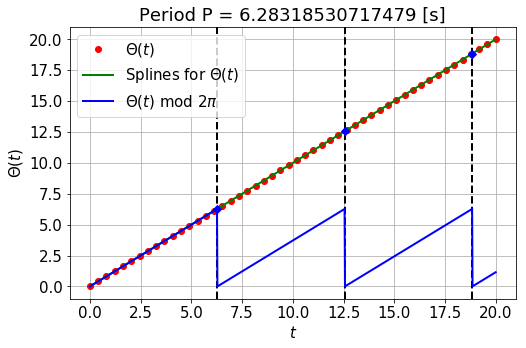

In [49]:
Theta = solve_IVP(w,20,True)

As expected, since the speed $\omega$ in this case is $\omega(\theta) = 1$, a constant value. The position $\Theta$ in time is the function $\Theta(t) = t$, the identity function. If a different scalar value was used, the solution of the Initial Value Problem would be a multiple of the identity function by exactly this scalar value. The numerical method used in this case is appropiated since reflects the behavior of the solution. The period $P$ in this case corresponds to the value $P = 2\pi \approx 6.28312$.

The next step is to solve the Partial Differential Equation asociated to $A_0(s,T)$:

$$
\frac{\partial A_0}{\partial T}(s,T) = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}(s,T)
$$


The next code solves the equation, mixing a numerical method for the integral and a finite difference method for the PDE.

In [56]:
i_widget = IntSlider(min=0, max=500, value=0)
interact(print_simulation_a0,i=i_widget)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.print_simulation_a0>

**Numerical Example**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= 1\\
\omega'(\theta) &= 0\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [19]:
def w(theta):
    return theta**0 
def wp(theta):
    return theta*0

def F(theta):
    return 2*np.sin(theta)

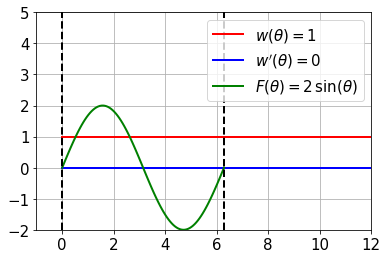

In [20]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.legend(loc="best")
plt.show()

In [21]:
def simulation(i,N,M,eps):
    def w(theta):
        return theta**0
    def wp(theta):
        return theta*0

    def F(theta):
        return 2*np.sin(theta)
    
    y1 = explicit_fft_method(w,wp,F,N,M,eps)
    y2 = implicit_method(w,wp,F,N,M,eps)
    
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,10,M)
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Explicit Fast Fourier Transform")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(1, 2, 2)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label="Implicit Finite Difference")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

In [22]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.],value=0, description='eps')
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(simulation,i=i_widget,N=N_widget,M=M_widget, eps=eps_widget)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.simulation>

In this particular case, $\Theta(t) = t$, since $\omega(\theta) = 1$. So, it is necessary to solve the PDE:

$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\tau-s)} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{1} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{\partial^2A_0}{\partial s^2}\\
\end{aligned}
$$

That is an usual Diffusion Equation with Difusivity coefficient equal to 1. The initial condition is:

$$
\begin{aligned}
A_0(s,0) &= F(\Theta(-s))\omega(\Theta(-s))\\
&= F(-s)\omega(-s)\\
&= F(-s)\\
&= 2\,\sin{(-s)}\\
&= -2\,\sin{(s)}\\
\end{aligned}
$$

And the variable $s$ has periodic conditions.

The following code solves the Partial Differential Equation
$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= \frac{\partial^2A_0}{\partial s^2}\\
A_0(s,0)&= -2\,\sin{(s)}\\
\end{aligned}
$$
using an implicit method.

In [23]:
eps = 10**-3
n_s = 10
s = np.linspace(0,2*np.pi,n_s+1)
#print(s)
delta_s = s[1]-s[0]
delta_T = 0.1

sigma = delta_T/(delta_s**0.5)

A = np.diag((1+2*sigma)*np.ones(n_s))+np.diag((-sigma)*np.ones(n_s-1),1)+np.diag((-sigma)*np.ones(n_s-1),-1)
A[-1,0] = -sigma
A[0,-1] = -sigma
#print(A)

sols = np.zeros((n_s,101))
sols[:,0] = -2*np.sin(s[:-1])

for i in range(1,101):
    sols[:,i] = np.linalg.solve(A,sols[:,i-1])


The next function is made in order to use a widget that visualizes the evolution of $A_0(s,T)$ for values of $T$ such that $T \in []$ 

In [24]:
def print_simulation(i):
    x = s[:-1]
    y = sols
    plt.ylim(-3,3)
    plt.grid(True)
    plt.xlabel("$s$")
    plt.ylabel("$A_0(s,T)$")
    plt.title("t = "+str(delta_T*i/eps))
    plt.plot(x,y[:,i],"ro")
    plt.show()
interact(print_simulation,i=(0,100))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.print_simulation>

The previous result can be interpretated as a really slow diffusion process, since the slow scale is involved. For big values of $t$ the changes in terms of diffusion will be noticed.

**Numerical Example 2**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= \sin^2{\left(\frac{\theta}{2}+\frac{1}{2}\right)}\\
\omega'(\theta) &= \frac{1}{2}\sin{(\theta+1)}\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [61]:
def w(theta):
    return (np.sin(0.5*theta))**2+0.5
    #return (np.cos(0.5*theta))**2+0.5
    return theta**0
def wp(theta):
    return 0.5*np.sin(theta)
    #return -2*np.sin(2*theta)
    return theta*0
def F(theta):
    #return (-theta**2+2*np.pi*theta)*0.5
    return 2*np.sin(theta)

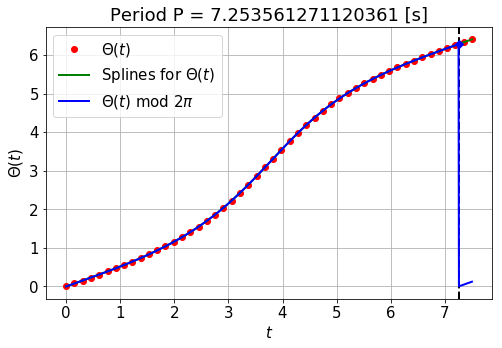

0.85905402242533713

In [65]:
Theta = solve_IVP(w,7.5,True)

In [76]:
lista = [0.5*np.pi, 1.0*np.pi,1.5*np.pi, 2.0*np.pi]
for th_hat in lista:
    #th_hat = 0.5*np.pi
    T = lambda x: Theta(x)-th_hat
    x = bisect(T,0,7.5)
    print(th_hat, x)
    
print("->",Theta(2.47))

1.5707963267948966 2.4700183670415754
3.141592653589793 3.710879255584132
4.71238898038469 4.889733285801867
6.283185307179586 7.253561271120361
-> 1.57077862859


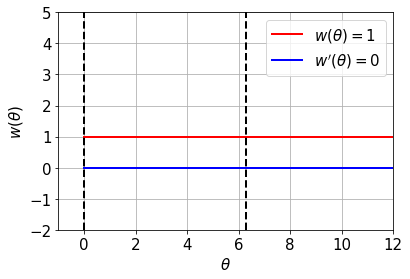

In [26]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
#plt.plot(th,w(th),"-r",label=r"$w(\theta) = \cos^2{\left(\frac{\theta}{2}\right)+\frac{1}{2}}$")
#plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = \frac{1}{2}\sin{(\theta)}$")
#plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$w(\theta)$")
plt.legend(loc="best")
plt.savefig("omega.pdf")
plt.show()


In [27]:
def simulation2(i,N,M,eps):
    def w(theta):
        return (np.sin(0.5*theta))**2+0.5
        
    def wp(theta):
        return 0.5*np.sin(theta)
        
    def F(theta):
        return 2*np.sin(theta)
    
    y1 = explicit_fft_method(w,wp,F,N,M,eps)
    y2 = implicit_method(w,wp,F,N,M,eps)
    
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Explicit Fast Fourier Transform")
    plt.ylim(-5,4)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(1, 2, 2)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label="Implicit Finite Difference")
    plt.ylim(-5,4)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

In [28]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.],value=0, description='eps')
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(simulation2,i=i_widget,N=N_widget,M=M_widget, eps=eps_widget)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.simulation2>

In [29]:
i_widget = IntSlider(min=0, max=500, value=0)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.0001,0.00001],value=1, description='eps')
interact(print_simulation_a0,i=i_widget,eps=eps_widget)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.print_simulation_a0>

In [30]:
i_widget = IntSlider(min=0, max=500, value=0)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.0001,0.00001],value=1, description='eps')
interact(print_simulation_f0,i=i_widget,eps=eps_widget)

NameError: name 'print_simulation_f0' is not defined

## References
[1] Jupyter Notebooks of SC1. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC1.

[2] Jupyter Notebooks of SC2. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC2.

[3] Jupyter Notebooks of SC5. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC5.

[4] Using observe to update values in a widget. http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Arguments-that-are-dependent-on-each-other